In [1]:
import torch
import torch.nn as nn
from torch.functional import F
import numpy as np
import pandas as pd

## Reproducibility

In [2]:
torch.manual_seed(0)
np.random.seed(0)

## Download

In [3]:
# !kaggle datasets download -d snap/amazon-fine-food-reviews

In [4]:
# import zipfile
# zipfile.ZipFile('amazon-fine-food-reviews.zip').extractall('.')

In [5]:
df = pd.read_csv('Reviews.csv')

In [6]:
df = df[['Text', 'Score']]

In [7]:
df['Length'] = df['Text'].apply(len)

In [8]:
df = df[df['Length'] <= 500]

In [9]:
df.groupby('Score').agg('count')

,Text,Length
Score,,
1,36599,36599
2,19853,19853
3,27125,27125
4,53400,53400
5,277850,277850


In [10]:
df_1s = df[df['Score']==1]

In [11]:
df_5s = df[df['Score']==5]

In [12]:
len(df_1s), len(df_5s)

(36599, 277850)

In [13]:
df_5s = df_5s.sample(len(df_1s), random_state=0)

In [14]:
len(df_1s), len(df_5s)

(36599, 36599)

<AxesSubplot:>

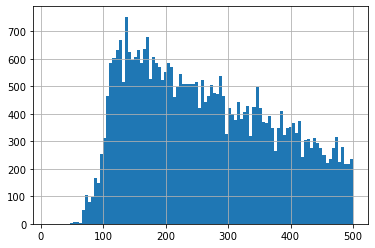

In [15]:
df_1s['Length'].hist(bins=100)

<AxesSubplot:>

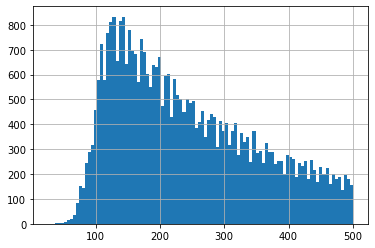

In [16]:
df_5s['Length'].hist(bins=100)

In [17]:
df_1s['Length'].mean(), df_5s['Length'].mean()

(264.7288723735621, 242.80302740512036)

## Final dataset and splits

In [18]:
# create full dataset
df_full = pd.concat([df_1s, df_5s])

In [19]:
len(df_full)

73198

In [20]:
cut = int(.8*len(df_full))
cut

58558

In [21]:
# shuffle
df_full = df_full.sample(frac=1, random_state=0)

In [22]:
df_train = df_full[:cut]

In [23]:
df_val = df_full[cut:]

In [24]:
len(df_train), len(df_val)

(58558, 14640)

Make sure they are still balanced:

In [25]:
df_train.groupby('Score').agg('count')

,Text,Length
Score,,
1,29205,29205
5,29353,29353


In [26]:
df_val.groupby('Score').agg('count')

,Text,Length
Score,,
1,7394,7394
5,7246,7246


## Handling batches with pandas

In [27]:
fulltext = df_train['Text'].str.cat()

In [28]:
from collections import Counter

In [29]:
tok_ctr = Counter(fulltext)

In [30]:
len(tok_ctr)

105

In [31]:
vocab = ['unk', 'pad'] + [tok for tok,count in tok_ctr.most_common()]
vocab

['unk',
 'pad',
 ' ',
 'e',
 't',
 'a',
 'o',
 'i',
 's',
 'r',
 'n',
 'h',
 'l',
 'd',
 'u',
 'c',
 'y',
 'f',
 'm',
 'g',
 '.',
 'p',
 'b',
 'w',
 'v',
 'I',
 'k',
 ',',
 'T',
 "'",
 '!',
 'A',
 'S',
 '/',
 'x',
 'E',
 'O',
 '>',
 '<',
 '-',
 'N',
 'W',
 'M',
 'z',
 'C',
 'j',
 'B',
 'H',
 'R',
 'D',
 'L',
 '"',
 'G',
 'P',
 '0',
 '1',
 'F',
 '2',
 'Y',
 ')',
 'q',
 'U',
 '(',
 'V',
 'K',
 '5',
 '3',
 '?',
 '4',
 '$',
 'J',
 '6',
 '9',
 ':',
 '8',
 '&',
 '7',
 ';',
 'Z',
 '%',
 '=',
 'Q',
 'X',
 '+',
 '*',
 '[',
 ']',
 '#',
 '~',
 '@',
 '_',
 '`',
 '®',
 '^',
 '}',
 '\\',
 '{',
 '°',
 '¢',
 '|',
 'Î',
 '½',
 'ç',
 '×',
 '£',
 '¼',
 'û']

In [32]:
tok2num = {tok:num for num,tok in enumerate(vocab)}
num2tok = {num:tok for num,tok in enumerate(vocab)}

In [33]:
def encode_text(s):
    return torch.tensor([tok2num[c] if c in tok2num.keys() else 0 for c in s])

In [34]:
# test unknown character
encode_text('abcݭ')

tensor([ 5, 22, 15,  0])

In [35]:
tag_vocab = [1,5]
tag_vocab

[1, 5]

In [36]:
tag2num = {tag:num for num,tag in enumerate(tag_vocab)}
num2tag = {num:tag for num,tag in enumerate(tag_vocab)}

In [37]:
tag2num, num2tag

({1: 0, 5: 1}, {0: 1, 1: 5})

## Batching

In [38]:
bs = 64
bucket_sz = bs * 20
bucket_sz

1280

In [39]:
import random
# get dataframe batches
def get_dfbs(dset, bucket_sz, bs):
    dset = dset.sort_values('Length')
    batches = []
    for i in range(0,len(dset),bucket_sz):
        start = i
        end = i+bucket_sz
        if end > len(dset):
            end = len(dset)
        bucket = dset[start:end]
        bucket = bucket.sample(frac=1, random_state=0)
        for j in range(0,len(bucket), bs):
            start = j
            end = j+bs
            if end > len(bucket):
                end = len(bucket)
            batch = bucket[start:end]
            batches.append(batch)
    random.shuffle(batches)
    return batches

In [40]:
# pad a tensor to a certain size, with 1s
def pad_to(t, sz):
    padded = torch.ones(sz)
    padded[:len(t)] = t
    return padded.long()

In [41]:
# convert a dataframe batch to a tensor batch
def dfb2tens(dfb):
    # x batch
    xb = dfb['Text']
    pad_sz = dfb['Length'].max()
    xb = [encode_text(s) for s in xb]
    xb = torch.stack([pad_to(t, pad_sz) for t in xb])
    # y batch
    yb = dfb['Score']
    yb = yb.apply(lambda x: torch.tensor(tag2num[x]))
    yb = torch.stack(yb.tolist())
    
    return xb, yb

In [42]:
# get a new set of batches for training an epoch
def get_batches(dset, bucket_sz, bs):
    for dfb in get_dfbs(dset, bucket_sz, bs):
        xb, yb = dfb2tens(dfb)
        yield xb, yb

## Model

In [43]:
class FoodsModel(nn.Module):
    def __init__(self, vocab_sz, emb_sz, hid_sz):
        super().__init__()
        self.emb = nn.Embedding(vocab_sz, emb_sz)
        self.lstm = nn.LSTM(emb_sz, hid_sz, 1, batch_first=True)
        self.lin = nn.Linear(hid_sz, 1)
        
    def forward(self, x):
        out = self.emb(x)
        out,_ = self.lstm(out)
        out = self.lin(out)
        return out # return all sequence outputs

In [44]:
emb_sz = 50
hid_sz = 100

In [45]:
model = FoodsModel(len(vocab), emb_sz, hid_sz)

## Loss

In [46]:
def foods_loss(preds, targs):
    preds = preds.squeeze(dim=-1).mean(dim=-1) # pool all outputs into an average score
    targs = targs.float()
    return F.binary_cross_entropy_with_logits(preds, targs)

## Optimizer

In [47]:
opt = torch.optim.Adam(model.parameters(), lr=.01)

## Metric

In [48]:
def accuracy(preds, targ):
    preds = preds.squeeze(dim=-1).mean(dim=-1) # pool all outputs into an average score
    return ((preds > 0).float() == targ.float()).float().mean()

## Train

In [49]:
def train_epoch():
    for xb, yb in get_batches(df_train, bucket_sz, bs):
        preds = model(xb)
        loss = foods_loss(preds, yb)
        loss.backward()
        opt.step()
        opt.zero_grad()

In [50]:
def val_epoch():
    losses = []
    accs = []
    with torch.no_grad():
        for xb, yb in get_batches(df_val, bucket_sz, bs):
            preds = model(xb)
            loss = foods_loss(preds, yb).item()
            losses.append(loss)
            acc = accuracy(preds, yb)
            accs.append(acc)
    avg_loss = torch.tensor(losses).mean().item()
    avg_acc = torch.tensor(accs).mean().item()
    return avg_loss, avg_acc

In [ ]:
train_epoch()

In [ ]:
val_loss, val_acc = val_epoch()
val_loss, val_acc

In [ ]:
def predict(text):
    tens = encode_text(text)
    tens = tens.unsqueeze(dim=0) # create batch of 1
    with torch.no_grad():
        out = model(tens).squeeze()
    pred = out.mean(dim=-1)
    num = int((pred > 0).float().item())
    pred = num2tag[num]
    return pred, out

In [ ]:
# predict with a random item from validation set
item = df_val.sample(n=1, random_state=0)
text = item['Text'].item()
score = item['Score'].item()
print(text)
print()
print(f'True score: {score}')
pred,out = predict(text)
print(f'Pred score: {pred}')

In [ ]:
# show prediction after each character
pd.set_option('display.max_rows', None)
pd.DataFrame({"Char":list(text), "Pred":out.numpy()})